<a href="https://colab.research.google.com/github/dushyanth-pulaparthi/FACE_MASK_DETECTION/blob/main/FACE_MASK_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow keras opencv-python numpy matplotlib


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 330M/330M [00:02<00:00, 121MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os

# Load dataset
dataset_path = "/root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1"  # Update path if needed

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load MobileNetV2 base model (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save model
model.save("mask_detector_model.h5")

print("Model saved as mask_detector_model.h5")


Found 9434 images belonging to 1 classes.
Found 2358 images belonging to 1 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 156s 492ms/step - accuracy: 0.9828 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 9.4471e-09
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 135s 458ms/step - accuracy: 1.0000 - loss: 2.7770e-09 - val_accuracy: 1.0000 - val_loss: 4.7809e-09
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 455ms/step - accuracy: 1.0000 - loss: 4.3620e-09 - val_accuracy: 1.0000 - val_loss: 6.1725e-09
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 453ms/step - accuracy: 1.0000 - loss: 3.7939e-09 - val_accuracy: 1.0000 - val_loss: 5.9840e-09
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 455ms/step - accuracy: 1.0000 - loss: 5.3215e-09 - val_accuracy: 1.0000 - val_loss: 1.0779e-08
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 454ms/step - accuracy: 1.0000 - loss: 3.3708e-09 - val_accuracy: 1.0000 - val_loss: 6.6119e-09
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 134s 456ms/step - accuracy: 1.0000 - loss: 4.3788e-09 - val_accuracy: 1.0000 - val_loss: 7.3421e-09
Epoch 8/10
295/295 ━━━━━

Model saved as mask_detector_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


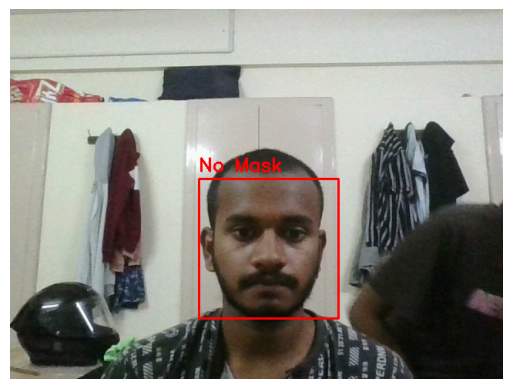

In [27]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained model
model = load_model("mask_detector_model.h5")

# Load OpenCV's face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# JavaScript to capture an image from the webcam
def take_photo():
    js = '''
        async function takePhoto() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise(resolve => video.onloadedmetadata = resolve);
            video.play();

            await new Promise(resolve => setTimeout(resolve, 500));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            video.remove();
            return canvas.toDataURL('image/jpeg', 1.0);
        }
        takePhoto();
    '''
    return eval_js(js)

# Capture image
image_data = take_photo()
image_bytes = b64decode(image_data.split(',')[1])

# Convert to numpy array
image_np = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Convert to grayscale for face detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

# Process detected faces
for (x, y, w, h) in faces:
    face = image[y:y+h, x:x+w]  # Extract face ROI
    face = cv2.resize(face, (224, 224)) / 255.0  # Resize and normalize
    face = np.expand_dims(face, axis=0)  # Add batch dimension

    # Predict mask/no mask
    prediction = model.predict(face)
    label = "Mask" if prediction[0][0] > 0.5 else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (255, 0, 0)

    # Draw rectangle and label
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Display the image
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
